# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Volatility Targeting

Volatility targeting is a technique that tries to keep the volatility of the portfolio as close to a target value as much it is possible. This is achieved by changing the position size of the trade, and hence the risk exposure. In this notebook, you will learn to implement position sizing using the volatility targeting technique on the index reversal strategy. The notebook is divided into the following parts:

1. [Read the Data](#read)
1. [Define the Parameters](#def)
1. [Volatility Calculation](#vol)
1. [Leverage and Portfolio Value Calculation](#lev)
1. [Portion of Capital](#capital)
1. [Leverage Ratio](#leverage)
    
## Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Quantra function to analyse the performance and plot graphs
import sys
sys.path.append("..")
from data_modules.position_sizing_quantra import performance_analysis, plot_leverage, plot_portion_of_capital

# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

<a id='read'></a>
## Read the Data

The SPY ETF data is read and the volatility targeting technique is applied to the index reversal strategy. The SPY ETF price is read from `SPY_data_15_59.csv` and the index reversal strategy's trading signal and the portfolio value are read from a file named `strategy_data.csv`.

In [2]:
# Read the price data of one minute before the market close
spy_price = pd.read_csv(
    '../data_modules/SPY_data_15_59.csv', index_col=0, parse_dates=True)

# Set the date as the index for the price data
spy_price.index = pd.to_datetime(spy_price.index.date)

# Read the signal and cumulative returns of the index reversal strategy
strategy = pd.read_csv('../data_modules/strategy_data.csv',
                       index_col=0, parse_dates=True)

# Preview the strategy data
strategy.head()

,signal,returns,cumulative_returns
2005-01-03,0,-0.000000,1.000000
2005-01-04,1,-0.000000,1.000000
2005-01-05,1,-0.003537,0.996463
2005-01-06,0,0.003296,0.999747
2005-01-07,0,-0.000000,0.999747


<a id='def'></a>
## Define the Parameters

The parameters for the volatility targeting position sizing technique are defined here.

In [3]:
# Define the initial capital
initial_capital = 10000

# Define the target volatility
volatility_target = 0.01

# Define the maximum cap for the leverage
leverage_cap = 2

<a id='vol'></a>
## Volatility Calculation

The volatility is calculated by finding the standard deviation of the asset returns. For illustration, the last 20 days are used for calculating the volatility on any given day.

The asset data starting from 1st January 2005 is considered so that the position sizing techniques can be compared with the performance results of the index reversal strategy.

In [4]:
# Calculate the asset returns
spy_price['returns'] = spy_price['Close'].pct_change()

# Calculate the volatility of the asset returns
spy_price['volatility'] = spy_price['returns'].rolling(20).std()

# Consider the data starting from 1st January 2005
spy_price = spy_price.loc['2005-01-01':]

<a id='lev'></a>
## Leverage and Portfolio Value Calculation

The following steps are performed to calculate the leverage and the portfolio value:
1. The leverage is calculated using the target volatility and the asset returns volatility.
1. The leverage is then multiplied by the strategy returns of the index reversal strategy to get the returns for the volatility targeting technique.
1. The cumulative returns are calculated by taking the cumulative product of the strategy returns.
1. The portfolio value is calculated by multiplying the cumulative returns with the initial capital.

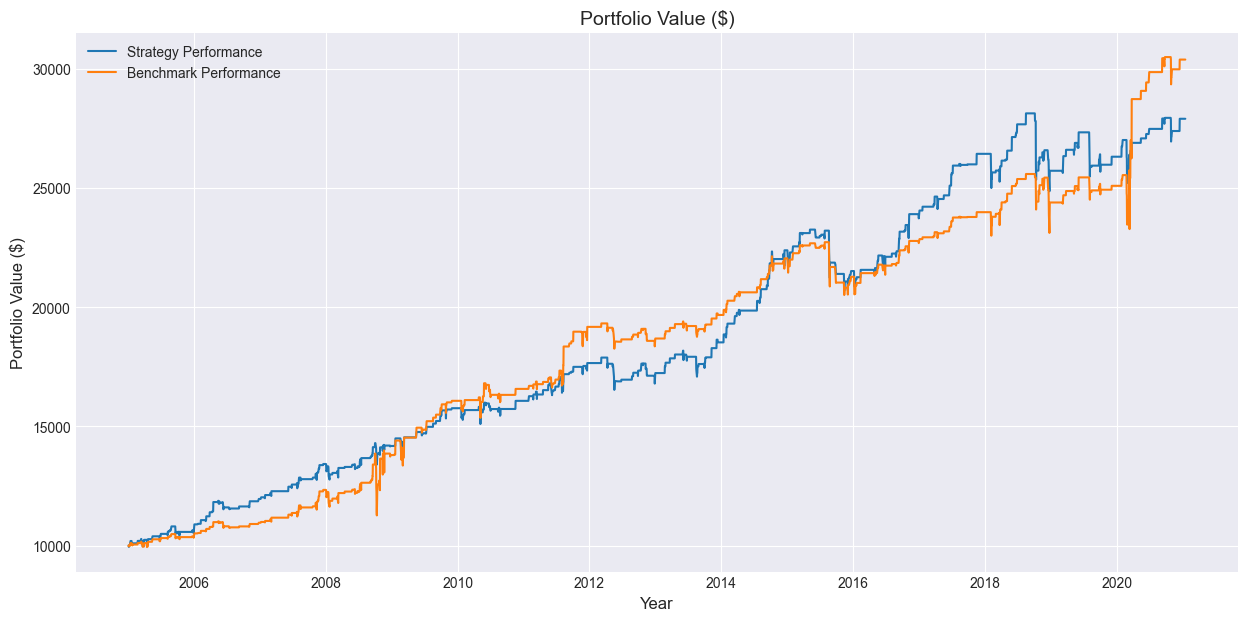

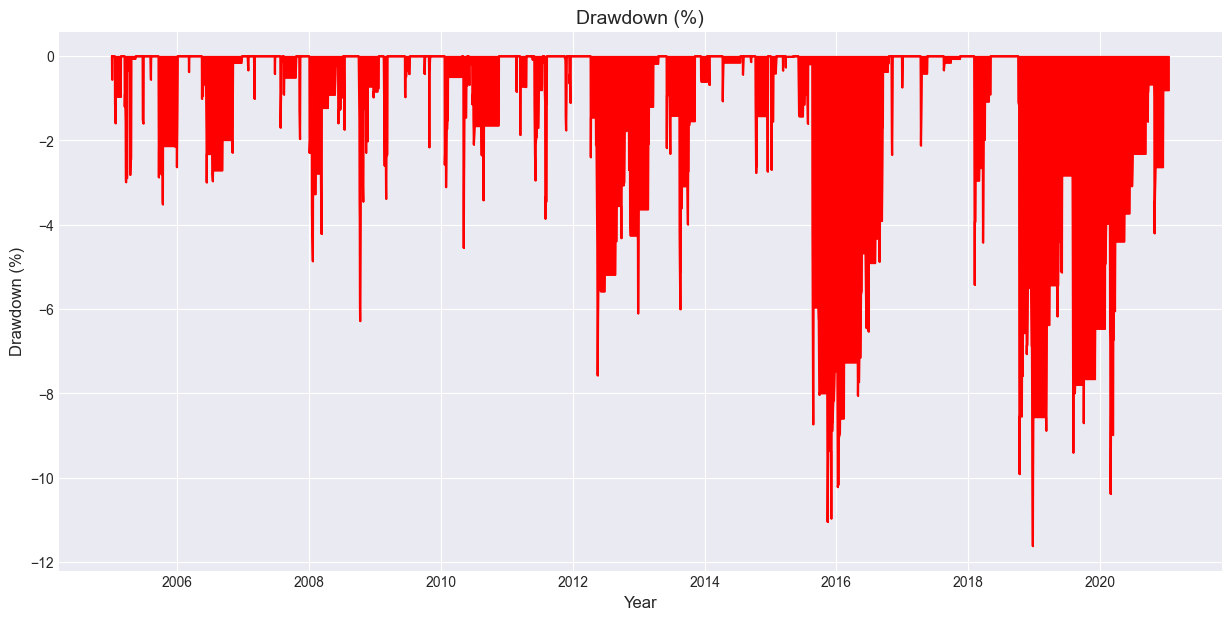

Total returns: 179.14%
Annualised returns (CAGR): 6.62%
Maximum drawdown (MDD): -11.62%
Return-to-MDD ratio: 0.57


In [5]:
# Dataframe to store strategy returns for fixed unit technique
volatility_targeting = pd.DataFrame()

# Calculate the leverage based on the target volatility
volatility_targeting['leverage'] = volatility_target / \
    spy_price['volatility'].shift(1)

# Cap the leverage to the maximum value
volatility_targeting['leverage'] = np.where(
    volatility_targeting['leverage'] > leverage_cap, leverage_cap, volatility_targeting['leverage'])

# Calculate the returns based on the calculated leverage
volatility_targeting['returns'] = strategy['returns'] * \
    volatility_targeting['leverage']

# Calculate the cumulative returns
volatility_targeting['cumulative_returns'] = (
    1 + volatility_targeting['returns']).cumprod()

# Caclulate the portfolio value
volatility_targeting['portfolio_value'] = volatility_targeting['cumulative_returns'] * initial_capital

# Get the volatility of only the days when the strategy trades
volatility_targeting['leverage'] = volatility_targeting['leverage'] * \
    strategy['signal']

# Calculate the performance metrics and plot the portfolio value alongwith the benchmark
performance_analysis(
    volatility_targeting['portfolio_value'].dropna(),
    strategy['cumulative_returns']*initial_capital
)

<a id='capital'></a>
## Portion of Capital

The portion of capital is the wealth used in each trade. The portion of capital used is leverage times the benchmark strategy portfolio value.

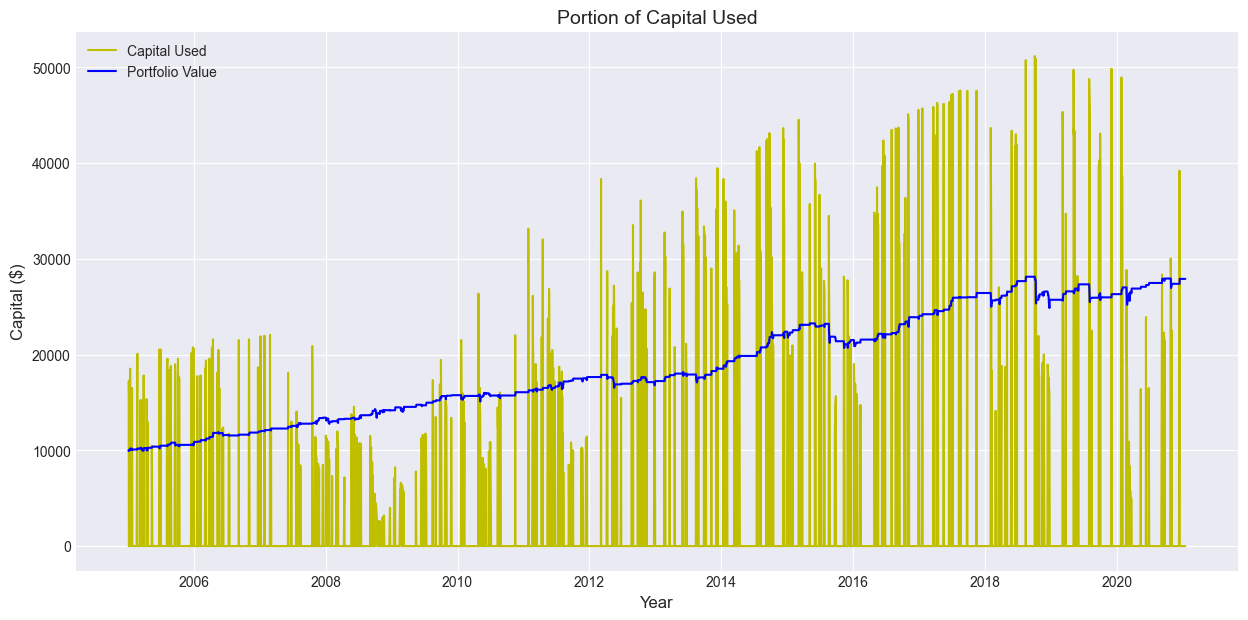

In [6]:
# Portion of capital used
volatility_targeting['portion_of_capital'] = volatility_targeting['leverage'] * \
    strategy['cumulative_returns'] * initial_capital

# Plot the portion of capital used
plot_portion_of_capital(
    volatility_targeting['portion_of_capital'], volatility_targeting['portfolio_value'])

The portion of capital used was mostly above the portfolio value (leverage > 1). It went below the portfolio value in times of market uncertainty (like the 2008 financial crisis and the 2020 COVID pandemic).

<a id='leverage'></a>
## Leverage Ratio
The leverage ratio calculated above will be plotted here.

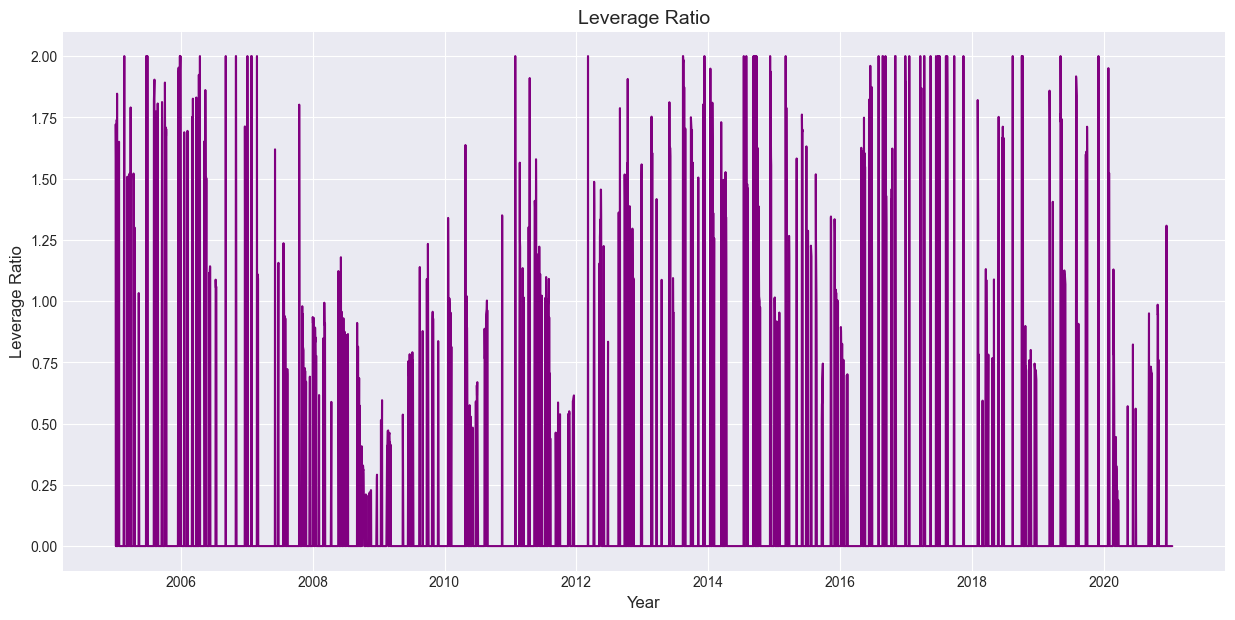

In [7]:
# Plot the leverage ratio
plot_leverage(volatility_targeting['leverage'])

The leverage can be seen to be capped at 2, as it was defined in our parameters. The leverage ratio reduced when the markets were highly volatile (around the years 2008 and 2020).

## Tweak the code
You can tweak the code as follows:

1. Use different values of `volatility_target` and see how the performance varies with a different volatility target.
1. Use different values of `leverage_cap` and see how the performance varies with a different value of maximum leverage.

In the upcoming section, you will learn about the constant proportion portfolio insurance (CPPI) technique.
<br><br>